In [21]:
import pandas as pd
import numpy as np
import os
import cudf
import cupy as cp
import helpers

## Step1: Data Preprocessing

In [22]:
path1 = '/mnt/share/Zidi/auction_factor_result_trial'
path2 = '/mnt/share/Zidi/auction_factor_result_2022'
path3 = '/mnt/share/Zidi/auction_factor_result_2023'

df1 = helpers.concat_factor(path1)
df2 = pd.concat([helpers.concat_factor(path2), helpers.concat_factor(path3)])

In [23]:
all_factor = df1.merge(df2, on=['Date', 'code'], how='inner')
all_factor = all_factor.sort_values(by=['Date', 'code'])
all_factor.head()

,Date,code,buy_cancel_amt,sell_cancel_amt,buy_order_amt_920,sell_order_amt_920,buy_order_amt_925,sell_order_amt_925,buy_trade_amt_920,sell_trade_amt_920,...,buy_order_vol1,sell_order_vol1,buy_order_vol2,sell_order_vol2,price1,max_trade_vol1,price2,max_trade_vol2,price3,max_trade_vol3
0,20220104,1,4529283.0,883705.0,569282060000,1410157708000,143053660000,372355859400,48383530000,46583380000,...,3519000.0,8169780.0,874600.0,2235929.0,165000.0,290500.0,165000.0,317700.0,164800.0,1057909
1,20220104,2,507858.0,1975215.0,442686570000,1075990977600,169997660000,615832937900,27924940000,27326540000,...,2313700.0,5231501.0,872900.0,3117101.0,196500.0,141300.0,196500.0,156300.0,194900.0,1085800
2,20220104,9,4541339.0,2730270.0,193412510000,502240279800,75744670000,256998110000,20780150000,20324170000,...,1343900.0,3282001.0,518800.0,1725000.0,146800.0,139700.0,147800.0,370900.0,146500.0,492700
3,20220104,12,4860.0,104874.0,41734490000,148749579100,16457140000,52868370000,2888160000,2699960000,...,434300.0,1416433.0,166100.0,517300.0,99900.0,28000.0,99800.0,36800.0,99000.0,179800
4,20220104,21,499365.0,756990.0,38484260000,132826370000,13814220000,53734030000,3382820000,3289530000,...,248200.0,798000.0,88400.0,316100.0,158000.0,21200.0,156000.0,61100.0,158000.0,55500


## Step2: Calculating Factor

In [24]:
all_factor['buy_cancel_price'] = all_factor['buy_cancel_amt'] / all_factor['buy_cancel_vol1']
all_factor['sell_cancel_price'] = all_factor['sell_cancel_amt'] / all_factor['sell_cancel_vol1']

all_factor['buy_order_price_920'] = all_factor['buy_order_amt_920'] / all_factor['buy_order_vol1']
all_factor['sell_order_price_920'] = all_factor['sell_order_amt_920'] / all_factor['sell_order_vol1']

all_factor['buy_order_price_925'] = all_factor['buy_order_amt_925'] / all_factor['buy_order_vol2']
all_factor['sell_order_price_925'] = all_factor['buy_order_amt_925'] / all_factor['sell_order_vol2']

all_factor['buy_trade_price_920'] = all_factor['buy_trade_amt_920'] / all_factor['max_trade_vol1']
all_factor['sell_trade_price_920'] = all_factor['sell_trade_amt_920'] / all_factor['max_trade_vol1']

all_factor['buy_trade_price_925'] = all_factor['buy_trade_amt_925'] / all_factor['max_trade_vol3']
all_factor['sell_trade_price_925'] = all_factor['sell_trade_amt_925'] / all_factor['max_trade_vol3']

In [25]:
all_factor.shape

(343837, 38)

In [26]:
price_factor = all_factor[['Date','code','buy_cancel_price','sell_cancel_price','buy_order_price_920','sell_order_price_920','buy_order_price_925','sell_order_price_925','buy_trade_price_920','sell_trade_price_920','buy_trade_price_925','sell_trade_price_925','price1','price2']]
cols_to_scale = [
    'buy_order_price_920', 'sell_order_price_920',
    'buy_order_price_925', 'sell_order_price_925',
    'buy_trade_price_920', 'sell_trade_price_920',
    'buy_trade_price_925', 'sell_trade_price_925',
    'price1', 'price2'
]

price_factor[cols_to_scale] = price_factor[cols_to_scale] / 10000

cols_to_log = [col for col in price_factor.columns if col not in ['Date', 'code']]
price_factor[cols_to_log] = np.log(price_factor[cols_to_log]+1e-10)

price_factor = price_factor.dropna(how='any')
price_factor

/tmp/ipykernel_108248/421444482.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_factor[cols_to_scale] = price_factor[cols_to_scale] / 10000
/home/mzd/miniconda3/envs/cupy-env/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_108248/421444482.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_factor[cols_to_log] = np.log(price_factor[cols_to_log]+1e-10)


,Date,code,buy_cancel_price,sell_cancel_price,buy_order_price_920,sell_order_price_920,buy_order_price_925,sell_order_price_925,buy_trade_price_920,sell_trade_price_920,buy_trade_price_925,sell_trade_price_925,price1,price2
0,20220104,1,2.817677,2.815720,2.783614,2.848430,2.794623,1.855978,2.812726,2.774810,2.806452,2.775995,2.803360,2.803360
1,20220104,2,2.972105,2.983262,2.951429,3.023714,2.969134,1.696296,2.983805,2.962143,2.976813,2.949300,2.978077,2.978077
2,20220104,9,2.736717,2.706502,2.666664,2.728040,2.681020,1.479556,2.699671,2.677484,2.694813,2.662067,2.686486,2.693275
3,20220104,12,2.274186,2.301384,2.262763,2.351537,2.293340,1.157307,2.333585,2.266203,2.304596,2.282621,2.301585,2.300583
4,20220104,21,2.750731,2.680031,2.741185,2.812104,2.748997,1.474810,2.769879,2.741914,2.764262,2.749198,2.760010,2.747271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343832,20231229,603986,4.512627,4.547263,4.513692,4.572932,4.515413,3.920939,4.579805,4.515787,4.538978,4.513025,4.530662,4.530231
343833,20231229,603993,1.612101,1.642778,1.616573,1.687236,1.633751,1.009453,1.644709,1.613059,1.649814,1.615320,1.637053,1.637053
343834,20231229,605117,4.425498,4.402858,4.394539,4.465298,4.421569,4.829825,4.430481,4.353524,4.437732,4.374151,4.412798,4.414978
343835,20231229,605358,3.297901,3.300012,3.281267,3.353031,3.287615,3.111421,3.317025,3.296768,3.318254,3.297686,3.305971,3.305787


In [27]:
stock_800 = pd.read_csv('/mnt/share/Zidi/project2/stock_800.csv')[[
    'Symbol', 'Date', 'return_inday','return_overnight', 'return_1min',
    'return_5min', 'return_10min', 'return_30min', 'return_1hr', 'return_2hr'
    ]]
price_factor = price_factor.drop(columns=['buy_cancel_price','sell_cancel_price'])

df_merge = price_factor.merge(stock_800, left_on=['code', 'Date'], right_on=['Symbol', 'Date'], how='left').drop(columns=['Symbol'])

In [28]:
df_merge.loc[:,'buy_force'] = (df_merge['buy_trade_price_925']-df_merge['price2'])/df_merge['price2']
df_merge.loc[:,'sell_force'] = (df_merge['price2']-df_merge['sell_trade_price_925'])/df_merge['price2']
df_merge.loc[:,'rise_power'] = df_merge['buy_force']/df_merge['sell_force']
df_merge.loc[:,'return_oo'] = (1+df_merge['return_inday'])*(1+df_merge['return_overnight'])-1
df_merge.loc[:,'return_oo_1'] = (1+df_merge['return_oo'])/(1+df_merge['return_1min']) -1
df_merge = df_merge.dropna()

In [29]:
df_merge.head()

,Date,code,buy_order_price_920,sell_order_price_920,buy_order_price_925,sell_order_price_925,buy_trade_price_920,sell_trade_price_920,buy_trade_price_925,sell_trade_price_925,...,return_5min,return_10min,return_30min,return_1hr,return_2hr,buy_force,sell_force,rise_power,return_oo,return_oo_1
0,20220104,1,2.783614,2.848430,2.794623,1.855978,2.812726,2.774810,2.806452,2.775995,...,-0.007888,-0.014563,-0.015777,-0.012743,-0.004248,0.001103,0.009762,0.112967,0.006068,0.007290
1,20220104,2,2.951429,3.023714,2.969134,1.696296,2.983805,2.962143,2.976813,2.949300,...,-0.003079,0.000513,0.029759,0.038481,0.051821,-0.000425,0.009663,-0.043950,0.048230,0.048768
2,20220104,9,2.666664,2.728040,2.681020,1.479556,2.699671,2.677484,2.694813,2.662067,...,-0.020492,-0.019809,-0.035519,-0.050546,-0.051913,0.000571,0.011588,0.049293,-0.043716,-0.039781
3,20220104,12,2.262763,2.351537,2.293340,1.157307,2.333585,2.266203,2.304596,2.282621,...,0.006061,0.024242,-0.001010,-0.004040,0.006061,0.001744,0.007808,0.223399,0.000000,-0.003021
4,20220104,21,2.741185,2.812104,2.748997,1.474810,2.769879,2.741914,2.764262,2.749198,...,0.008228,0.006962,0.021519,0.017089,0.018354,0.006185,-0.000701,-8.817658,0.025316,0.018868


In [30]:
helpers.cal_cross_sectional_ic(df_merge[['code','Date','buy_force','sell_force','rise_power','return_oo']], ic_type='rankic').mean()

buy_force|return_oo     0.023418
sell_force|return_oo   -0.014353
rise_power|return_oo    0.016269
dtype: float64

## Step3: Construct Portfolio

In [ ]:
df_merge.loc[:,'group'] = df_merge.groupby('Date')['rise_power'].transform(lambda x: (80*x.rank(method='first')/len(x)).astype('int'))
df_merge

,Date,code,buy_order_price_920,sell_order_price_920,buy_order_price_925,sell_order_price_925,buy_trade_price_920,sell_trade_price_920,buy_trade_price_925,sell_trade_price_925,...,return_10min,return_30min,return_1hr,return_2hr,buy_force,sell_force,rise_power,return_oo,return_oo_1,group
0,20220104,1,2.783614,2.848430,2.794623,1.855978,2.812726,2.774810,2.806452,2.775995,...,-0.014563,-0.015777,-0.012743,-0.004248,0.001103,0.009762,0.112967,0.006068,0.007290,18
1,20220104,2,2.951429,3.023714,2.969134,1.696296,2.983805,2.962143,2.976813,2.949300,...,0.000513,0.029759,0.038481,0.051821,-0.000425,0.009663,-0.043950,0.048230,0.048768,12
2,20220104,9,2.666664,2.728040,2.681020,1.479556,2.699671,2.677484,2.694813,2.662067,...,-0.019809,-0.035519,-0.050546,-0.051913,0.000571,0.011588,0.049293,-0.043716,-0.039781,15
3,20220104,12,2.262763,2.351537,2.293340,1.157307,2.333585,2.266203,2.304596,2.282621,...,0.024242,-0.001010,-0.004040,0.006061,0.001744,0.007808,0.223399,0.000000,-0.003021,23
4,20220104,21,2.741185,2.812104,2.748997,1.474810,2.769879,2.741914,2.764262,2.749198,...,0.006962,0.021519,0.017089,0.018354,0.006185,-0.000701,-8.817658,0.025316,0.018868,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338840,20231228,603893,4.135212,4.162247,4.116439,3.787666,4.204394,4.108447,4.137372,4.104986,...,-0.007340,-0.002610,0.009623,0.020878,-0.009797,0.017549,-0.558308,0.016963,0.025493,15
338841,20231228,603986,4.487719,4.557273,4.503975,3.870493,4.509049,4.508244,4.519208,4.490788,...,-0.011461,-0.003967,0.008155,0.010359,0.009107,-0.002761,-3.298318,0.017192,0.024304,5
338842,20231228,603993,1.601034,1.676883,1.628292,1.851801,1.645860,1.597115,1.651389,1.616394,...,0.017613,0.011742,0.017613,0.013699,0.018517,0.003067,6.037846,0.003914,-0.003883,74
338843,20231228,605117,4.356681,4.436408,4.374369,3.830075,4.415742,4.333262,4.395375,4.342973,...,0.020465,0.048888,0.038403,0.078828,0.003447,0.008516,0.404790,0.039161,0.047631,38


In [32]:
portfolio_daily_return = (
    df_merge
    .groupby(['Date', 'group'])['return_oo']
    .mean()
    .reset_index()
)

portfolio_daily_return = portfolio_daily_return.sort_values(by=['Date'])

## Step4: Evaluation

In [33]:
# 看看哪组的收益率表现最好
list1 = []
max_return = 0
max_group = 0
for i in range(1, 81):
    group_df = portfolio_daily_return[portfolio_daily_return['group']==i]
    group_df = group_df.sort_values(by=['Date'])
    cum_ret = (1 + group_df['return_oo']).cumprod()
    # 年化收益率
    if not cum_ret.empty:
        # print(cum_ret.iloc[-1])
        list1.append(cum_ret.iloc[-1])
        if cum_ret.iloc[-1] > max_return:
            max_return = cum_ret.iloc[-1]
            max_group = i
    else:
        print("该组为空，跳过")
    

print(max(list1),max_group)

1.6832398770972028 79


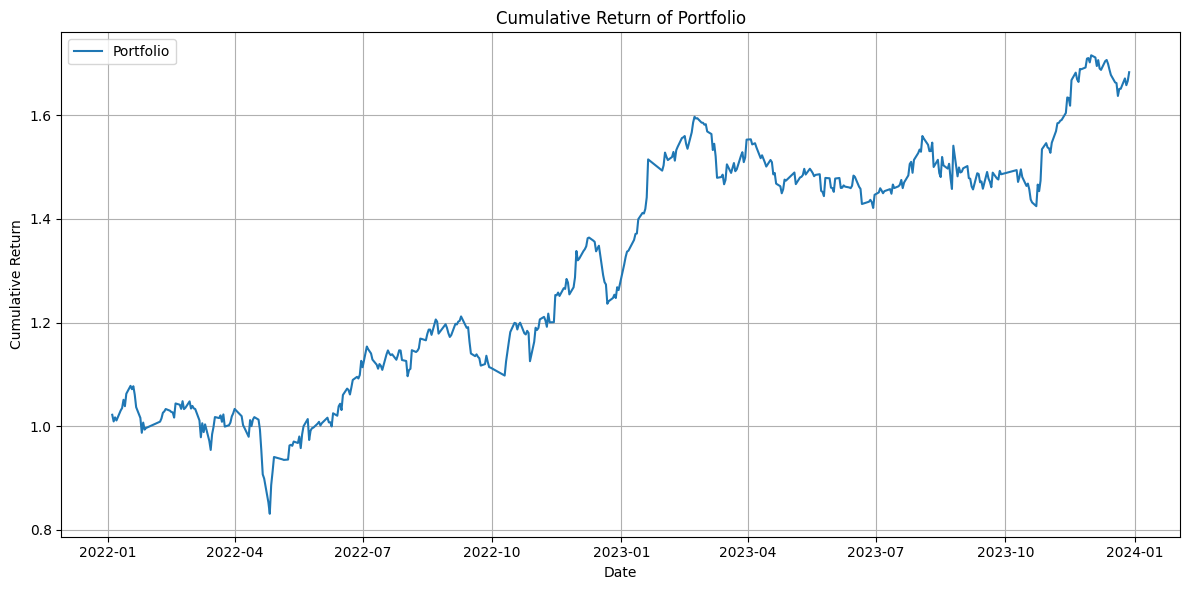

In [34]:
import matplotlib.pyplot as plt
# 选取最大的组构建投资组合
group_df = portfolio_daily_return[portfolio_daily_return['group']==max_group]


group_df = group_df.sort_values(by=['Date'])
group_df['cum_return'] = (1 + group_df['return_oo']).cumprod()
group_df = group_df.dropna()
group_df['Date'] = pd.to_datetime(group_df['Date'].astype('str'))

def plot_curve(df: cudf.DataFrame, horizontal_name: str, cum_return_name: str):
    plt.figure(figsize=(12, 6))
    plt.plot(df[horizontal_name], df[cum_return_name], label='Portfolio')
    plt.legend()
    plt.title("Cumulative Return of Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return None
plot_curve(group_df, 'Date', 'cum_return')

In [35]:
group_df

,Date,group,return_oo,cum_return
79,2022-01-04,79,0.021962,1.021962
160,2022-01-05,79,-0.012606,1.009079
241,2022-01-06,79,0.007814,1.016964
322,2022-01-07,79,-0.005871,1.010993
403,2022-01-10,79,0.019005,1.030207
...,...,...,...,...
38635,2023-12-22,79,0.000032,1.651215
38716,2023-12-25,79,0.012128,1.671240
38797,2023-12-26,79,-0.007791,1.658220
38878,2023-12-27,79,0.004897,1.666340


In [36]:
def cal_sharpe(df: pd.DataFrame, rf: float, return_name: str) -> int:
    df['excess_return'] = df[return_name] - rf/252
    return (np.sqrt(252)*group_df['excess_return'].mean())/(group_df[return_name]).std()

cal_sharpe(group_df, 0.017, 'return_oo')

1.245267765087324